# Introducton to Data Analysis -  Fairness in the COMPAS dataset classification

## Team Members:
-------------------------
- Mohammed Al-Marakby
- Eslam Mohammed

##### In this project we revisit the famous COMPAS dataset by showing some basic analysis of the system and its behavior towards the given data and feature. Moreover, we study the term of fairness in such context by comparing classifiers covered during the course with the existing COMPAS system. Finally, we will try to exhibit a fair classifier on the dataset and give a performance analysis in terms of fairness to be compared with the original one.

### 0.0 Notes

0. they have analysis for teh results
1. northpointe algorithm is biased towards black people
2. the used a set of 137 questions and "race" is not on of them
3. It produces a "risk score",, which is the likelihod of recommiting a future crime.
4. The score provies an unreliable forvcasting, only 20% of the people predictied to be recomminting actually did it
5. Tests isolating the effects of race, gender and age from criminal history and recedivism were done, but the algorithm still shows that black people are 77% more likely to be pegged as higherrisk of commiting a future crime and 45% more to ommit a future crime of any kind.

I have 2 main questions right now 
  1. How could an algorithm be unfair
  2. even after "5." it still shows the output is biased towards black 
     people, could it be that the questions are designed s.t the are r      racially biased and with the  goal to indict more black people 

### TODO:
0. Some descriptive stats.
1. histogram of black people that are predicted to recommit
2. histogram of white people that are predicted to reccomit
3. percentage of b;acl people that really recommited
4. percentage of white people that really recommited
5. Organization: add a magic line for installing plotly and ocra, add title for plots


## Part 2.1 - Dataset exploration

### Imports

In [1]:
import urllib
import urllib.request
import os,sys
import numpy as np
import pandas as pd
from functools import reduce
pd.set_option('display.max_columns',None)
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

try:
    import plotly.express as px
    import plotly.figure_factory as ff
    import plotly.io as pio
    import plotly.graph_objects as go
    pio.renderers.default = "notebook_connected"
except ImportError as e:
    !conda install --yes --prefix {sys.prefix} -c plotly plotly-orca==1.2.1 psutil requests
    



import sklearn.metrics as performance

# from sklearn import feature_extraction
# from sklearn import preprocessing
from random import seed, shuffle
#from __future__ import division
#from collections import defaultdict
#import utils as ut


In [40]:

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
fig=plt.figure(figsize=(10,6))
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



<Figure size 720x432 with 0 Axes>

In [2]:
# Function to display histogram of a given dataframe
def hist(column_name, x):
    return px.histogram(column_name, x = x,
                       title = 'Histogram of ' + x,
                       opacity = 0.8,
                       color_discrete_sequence = ['indianred'])
    

### Downlaod data file and dependency files

In [3]:

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file %s in the current directory..." % (fname))

    if fname not in files:
        print(" %s not found! Downloading from GitHub..." % fname)
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("%s download and saved locally.." % fname)
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  

Looking for file compas-scores-two-years.csv in the current directory...
File found in current directory..


### load and clean data
we followed the cleaning techniques described via the algorithm analysis page. 

In [4]:
dataset = pd.read_csv(COMPAS_INPUT_FILE)

print(dataset.shape)

dataset = dataset.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals

dataset = dataset[ (dataset.days_b_screening_arrest <= 30) &
(dataset.days_b_screening_arrest >= -30) &
(dataset.is_recid != -1) & (dataset.c_charge_degree != 'O') & (dataset.score_text != 'N/A') ]

dataset.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

(7214, 53)


In [43]:
dataset.head(10)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,0,1,0,0,0,0.0,2013-11-30 04:50:18,2013-12-01 12:28:56,13022355MM10A,2013-11-30,NaN,0.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-11-30,Risk of Violence,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
4,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,0,6,0,0,14,-1.0,2014-02-18 05:08:24,2014-02-24 12:18:30,14002304CF10A,2014-02-18,NaN,1.0,F,Possession Burglary Tools,1,14004485CF10A,(F2),0.0,2014-03-31,Poss of Firearm by Convic Felo,2014-03-31,2014-04-18,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2014-02-19,Risk of Violence,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1
5,9,steven stewart,steven,stewart,2013-08-30,Male,1973-02-25,43,25 - 45,Other,0,4,0,0,3,-1.0,2013-08-29 08:55:23,2013-08-30 08:42:13,13012216CF10A,NaN,2013-08-29,1.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-08-30,Risk of Violence,3,Low,2013-08-30,2014-05-22,2014-06-03,3,0,265,0,0
6,10,elizabeth thieme,elizabeth,thieme,2014-03-16,Female,1976-06-03,39,25 - 45,Caucasian,0,1,0,0,0,-1.0,2014-03-15 05:35:34,2014-03-18 04:28:46,14004524MM10A,2014-03-15,NaN,1.0,M,Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-03-16,Risk of Violence,1,Low,2014-03-16,2014-03-15,2014-03-18,0,2,747,0,0
7,14,benjamin franc,benjamin,franc,2013-11-26,Male,1988-06-01,27,25 - 45,Caucasian,0,4,0,0,0,-1.0,2013-11-25 06:31:06,2013-11-26 08:26:57,13016402CF10A,2013-11-25,NaN,1.0,F,"Poss 3,4 MDMA (Ecstasy)",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-11-26,Risk of Violence,4,Low,2013-11-26,2013-11-25,2013-11-26,0,0,857,0,0
8,15,ellyaher lanza,ellyaher,lanza,2013-10-03,Male,1992-08-18,23,Less than 25,African-American,0,6,0,0,3,0.0,2013-10-03 04:07:35,2013-10-07 08:17:30,13018837MM10A,2013-10-03,NaN,0.0,M,Battery,1,14010414TC40A,(M2),NaN,2014-02-08,Driving License Suspended,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,2013-10-03,Risk 

In [5]:
# How many NaN values in each column
for col in dataset.columns:
    print("Nan values in %s is %d" %(col, dataset[col].isna().sum()))

for col in dataset.columns:
    print(col)

Nan values in id is 0
Nan values in name is 0
Nan values in first is 0
Nan values in last is 0
Nan values in compas_screening_date is 0
Nan values in sex is 0
Nan values in dob is 0
Nan values in age is 0
Nan values in age_cat is 0
Nan values in race is 0
Nan values in juv_fel_count is 0
Nan values in decile_score is 0
Nan values in juv_misd_count is 0
Nan values in juv_other_count is 0
Nan values in priors_count is 0
Nan values in days_b_screening_arrest is 0
Nan values in c_jail_in is 0
Nan values in c_jail_out is 0
Nan values in c_case_number is 0
Nan values in c_offense_date is 784
Nan values in c_arrest_date is 5388
Nan values in c_days_from_compas is 0
Nan values in c_charge_degree is 0
Nan values in c_charge_desc is 5
Nan values in is_recid is 0
Nan values in r_case_number is 3182
Nan values in r_charge_degree is 3182
Nan values in r_days_from_arrest is 4175
Nan values in r_offense_date is 3182
Nan values in r_charge_desc is 3228
Nan values in r_jail_in is 4175
Nan values in r_j

In [7]:
# race,  priors_count, is_recid, is_violent_recid, 
# decile_score, score_text, v_decile_score, v_score_text, 

#ground truth: two_year_recid
#compas algorithm output: decile_score, v_decile_score


### Basic analysis of demographics
In order to analyze the demographic(sex, race) relations we decided to answer a set of fictitious questions with plots(mainly histograms) to gain an intuition about the population of the data.  
- What are the different races present in the dataset? 

- What is the number of people by age category?

- What is the number of people by race?

- What is the number of Males/Females per race?

- What is the number of people by COMPAS score (decile_score)?

- What is the number of people by COMPAS risk category (score_text)?

In [5]:
def get_basic_stats(column_name,check_values=None,
                    check_NaN=False,group_count=True,plot_hist = False):
    '''
    basic stats on a given column of the dataset
    @param column_name: column name to compute stats on
    '''
    
    result = {}
    
    if column_name not in dataset.columns:
        raise ValueError("column_name must be set to a value from the the available values")
        
    #values in the column
    column_values = np.unique(dataset[column_name].values)
    
    if check_values:
        print('-',column_name,"in dataset:")
        [print(value) for value in column_values]
#         result.append()

    if check_NaN:
        print("-NaN  presenti n the column?",dataset[column_name].isnull().any())
    
    if group_count:
        #values_count = dataset.groupby(column_name).count()
        #values_count.append([{value:(dataset[column_name] == value).sum()} for value in column_values ])
        
        values_count = dataset[column_name].value_counts()   
#         print('-values count:')
#         pprint(values_count)
        result.update(values_count=values_count)
        
    #histogram of values
    if plot_hist:
        fig = hist(dataset[column_name], column_name) 
        fig.show()        
    
    return result
    
        
result = get_basic_stats("race",plot_hist=True)

In [6]:
result = get_basic_stats("age", plot_hist=True)

It is quite obvious how imbalanced the dataset is. *Africane-Americans* are occupying more than half of the dataset then *Caucasians*. Also, a very high percentage of the defendants are *young-aged* (20 - 30)  

In [9]:

# result = get_basic_stats("race")
# print(result['values_count'])

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64


We know show the population of males and females in the given races.

In [7]:
sex_race_df = pd.crosstab(dataset.race, dataset.sex)
sex_race_df = sex_race_df.stack().reset_index().rename(columns={0:"value"})
sex_race_df

,race,sex,value
0,African-American,Female,549
1,African-American,Male,2626
2,Asian,Female,2
3,Asian,Male,29
4,Caucasian,Female,482
5,Caucasian,Male,1621
6,Hispanic,Female,82
7,Hispanic,Male,427
8,Native American,Female,2
9,Native American,Male,9


In [8]:
race = dataset.race.unique()
males = sex_race_df.value[sex_race_df.sex == 'Male']
females = sex_race_df.value[sex_race_df.sex == 'Female']

fig = go.Figure(data=[
    go.Bar(name='Male', x=race, y= males),
    go.Bar(name='Female', x=race, y=females)
])
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

*Male* is the most dominant sex here. Next, we compare the scores in each race. 

In [9]:
get_basic_stats('decile_score')

{'values_count': 1     1286
 2      822
 4      666
 3      647
 5      582
 6      529
 7      496
 9      420
 8      420
 10     304
 Name: decile_score, dtype: int64}

In [10]:
decile_score_per_race = pd.crosstab(dataset.decile_score, dataset.race)
decile_score_per_race = decile_score_per_race.stack().reset_index().rename(columns = {0:'values'})
decile_score_per_race

,decile_score,race,values
0,1,African-American,365
1,1,Asian,15
2,1,Caucasian,605
3,1,Hispanic,159
4,1,Native American,0
5,1,Other,142
6,2,African-American,346
7,2,Asian,4
8,2,Caucasian,321
9,2,Hispanic,89


In [11]:
dec_score = dataset.decile_score.unique()
afrac_amer = decile_score_per_race.values[decile_score_per_race.race == "African-American"][:,2]
hispanic = decile_score_per_race.values[decile_score_per_race.race == "Hispanic"][:,2]
asian = decile_score_per_race.values[decile_score_per_race.race == "Asian"][:,2]
causcasian = decile_score_per_race.values[decile_score_per_race.race == "Caucasian"][:,2]
native = decile_score_per_race.values[decile_score_per_race.race == "Native American"][:,2]
other = decile_score_per_race.values[decile_score_per_race.race == "Other"][:,2]

fig = go.Figure(data = [
    go.Bar(name = 'African-American', x = dec_score, y = afrac_amer),
    go.Bar(name = 'Hispanic', x = dec_score, y = hispanic),
    go.Bar(name = 'Asian', x = dec_score, y = asian),
    go.Bar(name = 'Causcasian', x = dec_score, y = causcasian),
    go.Bar(name = 'Native-American', x = dec_score, y = native),
    go.Bar(name = 'Other', x = dec_score, y = other)
])
fig.update_layout(barmode='stack')
fig.show()

From the above chart, we can see that more than **50%** of the *Afraican-Americans* are predicted to be high likely to commit felonies or recidivate, and consequently their scores lie in the medium to high risk ranges. 

These *low*, *medium* and *high* values are actually a sort of categories for the **decile_score** computed. That is it, a mapping of ranges in the score to each category. Will discuss it in more details in the upcoming sections.

In [12]:
get_basic_stats('score_text')

{'values_count': Low       3421
 Medium    1607
 High      1144
 Name: score_text, dtype: int64}

In [13]:
score_text_per_race = pd.crosstab(dataset.score_text, dataset.race)
score_text_per_race = score_text_per_race.stack().reset_index().rename(columns = {0:'values'})
score_text_per_race

,score_text,race,values
0,High,African-American,845
1,High,Asian,3
2,High,Caucasian,223
3,High,Hispanic,47
4,High,Native American,4
5,High,Other,22
6,Low,African-American,1346
7,Low,Asian,24
8,Low,Caucasian,1407
9,Low,Hispanic,368


In [14]:
dec_score = dataset.score_text.unique()
afrac_amer = score_text_per_race.values[score_text_per_race.race == "African-American"][:,2]
hispanic = score_text_per_race.values[score_text_per_race.race == "Hispanic"][:,2]
asian = score_text_per_race.values[score_text_per_race.race == "Asian"][:,2]
causcasian = score_text_per_race.values[score_text_per_race.race == "Caucasian"][:,2]
native = score_text_per_race.values[score_text_per_race.race == "Native American"][:,2]
other = score_text_per_race.values[score_text_per_race.race == "Other"][:,2]

fig = go.Figure(data = [
    go.Bar(name = 'African-American', x = dec_score, y = afrac_amer),
    go.Bar(name = 'Hispanic', x = dec_score, y = hispanic),
    go.Bar(name = 'Asian', x = dec_score, y = asian),
    go.Bar(name = 'Causcasian', x = dec_score, y = causcasian),
    go.Bar(name = 'Native-American', x = dec_score, y = native),
    go.Bar(name = 'Other', x = dec_score, y = other)
])
fig.update_layout(barmode='stack')
fig.show()

In [15]:
# number of african-american with score_text : high
result = get_basic_stats('score_text')
african_american_count_high = dataset[(dataset['race'] == 'African-American') & (dataset['score_text'] == 'High')].count()['id']
print("african america with compass score high: ",african_american_count_high)
print('percentage of african americans with high score {:.2f}%'.format(african_american_count_high /result['values_count']['High']*100))
print('\n')
# number of african-american with score_text : medium
african_american_count_medium = dataset[(dataset['race'] == 'African-American') & (dataset['score_text'] == 'Medium')].count()['id']
print("african america with compass score medium: ",african_american_count_medium)
print('percentage of african americans with medium score {:.2f}%'.format(african_american_count_medium /result['values_count']['Medium']*100))
print('\n')

# number of african-american with score_text : low
african_american_count_low = dataset[(dataset['race'] == 'African-American') & (dataset['score_text'] == 'Low')].count()['id']
print("african america with compass score low: ",african_american_count_medium)
print('percentage of african americans with low score {:.2f}%'.format(african_american_count_low /result['values_count']['Low']*100))
print('\n')


african america with compass score high:  845
percentage of african americans with high score 73.86%


african america with compass score medium:  984
percentage of african americans with medium score 61.23%


african america with compass score low:  984
percentage of african americans with low score 39.35%




### decile score vs race


In [45]:
def scores_stats(category, value):
    '''
    @param category: vategory to perform stats on
    @param value: entry in the specefied category
    '''
    scores = dataset[dataset[category] == value]
    scores = scores[['decile_score','score_text']]
    histogram,_ = np.histogram(scores['decile_score'])
    fig = px.histogram(scores['decile_score'], 'decile_score',
                       title = 'Decile score of '+ value,
                       opacity = 0.8,
                       color_discrete_sequence = ['indianred'])
    fig.add_shape(dict(
        type="line",
        x0 = scores['decile_score'].mean(),
        y0 = 0,
        x1 = scores['decile_score'].mean(),
        y1 = max(histogram) + 20,
        line=dict(
            color = "LightSeaGreen",
            width = 4,
            dash = "dashdot")
    ))
    fig.show()
    print('mean decile score: %.2f'%scores['decile_score'].mean())


In [46]:
#distribution and mean of decile score for african americans

scores_stats('race','African-American')

mean decile score: 5.28


In [47]:
#decile score vs race
# distribution of decile score for Caucasian

scores_stats('race','Caucasian')

mean decile score: 3.64


### decile score vs gender
#### TODO: add number of males and femals 

In [48]:
# distribution of decile score for males

scores_stats('sex','Male')

mean decile score: 4.50


In [49]:
# distribution of decile score for Females 

scores_stats('sex','Female')

mean decile score: 4.06


1. Compute basic performance metrics of the COMPAS classifier for different races/genders.

2. Do you see a difference? Are there other analyses that you could do to investigate how different races/genders are treated by the COMPAS classifier?

The two_year_recid field records whether or not each person was re-arrested for a violent offense within two years, which is what COMPAS is trying to predict.


1. How many people were re-arrested?


In [18]:
#people whom got re-arrested in two years span
dataset['two_year_recid'].sum()

2809

2. Compute the recidivism (i.e., people that got re-arrested) rates by race and gender


In [19]:
# recedivism bs race

dataset[(dataset['race'] == 'Caucasian') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

822

In [20]:
dataset[(dataset['race'] == 'African-American') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

1661

In [21]:
#recedivism by gender
dataset[(dataset['sex'] == 'Male') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

2396

In [22]:
dataset[(dataset['sex'] == 'Female') & (dataset['two_year_recid']==1)]['two_year_recid'].sum()

413

In [50]:
two_recide_sex_race_df = pd.crosstab(dataset.race[dataset.two_year_recid == 1], dataset.sex[dataset.two_year_recid == 1])
two_recide_sex_race_df = two_recide_sex_race_df.stack().reset_index().rename(columns={0:"value"})
two_recide_sex_race_df

,race,sex,value
0,African-American,Female,203
1,African-American,Male,1458
2,Asian,Female,1
3,Asian,Male,7
4,Caucasian,Female,170
5,Caucasian,Male,652
6,Hispanic,Female,26
7,Hispanic,Male,163
8,Native American,Female,2
9,Native American,Male,3


In [52]:
race = dataset.race.unique()
males = two_recide_sex_race_df.value[two_recide_sex_race_df.sex == 'Male']
females = two_recide_sex_race_df.value[two_recide_sex_race_df.sex == 'Female']

fig = go.Figure(data=[
    go.Bar(name='Male', x=race, y= males),
    go.Bar(name='Female', x=race, y=females)
], layout_title_text = "Population of Male/Female recidivism in race")
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [53]:
# Plot confusion matrix without passing the classifier
from sklearn.metrics import confusion_matrix
from itertools import cycle, product
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = 'd'
    thresh = cm.max() / 2
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def plot_conf_matrix(y_test, y_pred, class_names):
    print("plotting the Confusion Matrix")
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    print('CCR = {}'.format(np.trace(cnf_matrix) / len(y_test)))
    print('Precision = {}'.format(precision_macro_average(cnf_matrix)))
    print('Recall = {}'.format(recall_macro_average(cnf_matrix)))
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.show()
    
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

Here, to calculate the stats on COMPAS, we applied the same mapping of the score texts (low, medium and high) to ranges in the decile score such that:
- *low* maps form scores 1 to 4
- *medium* maps form scores 5 to 7
- *high* maps form scores 8 to 10

In [54]:
#mapping of low medium high to decile score
scores = dataset[['decile_score','score_text']]
low_range = scores[scores['score_text'] == 'Low']['decile_score']
print(low_range.min(),low_range.max())
medium_range = scores[scores['score_text'] == 'Medium']['decile_score']
print(medium_range.min(),medium_range.max())
High_range = scores[scores['score_text'] == 'High']['decile_score']
print(High_range.min(),High_range.max())

1 4
5 7
8 10


Then we considered the binary labeling of whether the defendant will recidivate or not by saying:
- *recidivate* means *high* = label *1*
- *will not recidivate* means *low/medium* = label *0*

### Performance analysis of COMPAS

In this sub-section, we measure COMPAS's overall performance and then look through the same for selected races and genders 

In [55]:
# we split scores to new classes, high to 1 and medium/ low to zero
new_scores = dataset.copy()
new_scores['decile_score'].replace(to_replace=range(1,8),value=0,inplace=True)
# new_scores['decile_score'].replace(to_replace=[5,6,7],value=1,inplace=True)
new_scores['decile_score'].replace(to_replace=range(8,11),value=1,inplace=True)


In [56]:
new_scores.decile_score.value_counts()

0    5028
1    1144
Name: decile_score, dtype: int64

The overall performance of the system

In [57]:
performance.accuracy_score(new_scores['two_year_recid'],new_scores['decile_score'],normalize=True)

0.6339922229423202

Now, we will not only consider the 2 most dominating races in the dataset; *African-American* and *Causcasian*. But also the gender itsel.

#### Accuracy for african american

plotting the Confusion Matrix
CCR = 0.6100787401574803
Precision = 0.6547616628996622
Recall = 0.6211659271642475
[[1303  211]
 [1027  634]]


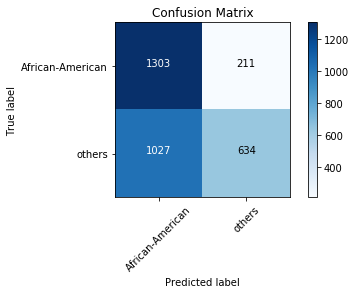

In [58]:
new_scores_african_american = new_scores[new_scores['race'] == 'African-American']
performance.accuracy_score(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'],normalize=True)

# performance.confusion_matrix(new_scores_african_american['two_year_recid'],new_scores_african_american['decile_score'])
plot_conf_matrix(new_scores_african_american['two_year_recid'], new_scores_african_american['decile_score'], class_names=['African-American', 'others'] )

### Accuracy for Caucasians

plotting the Confusion Matrix
CCR = 0.6571564431764146
Precision = 0.6876967846579525
Recall = 0.5747306221758777
[[1220   61]
 [ 660  162]]


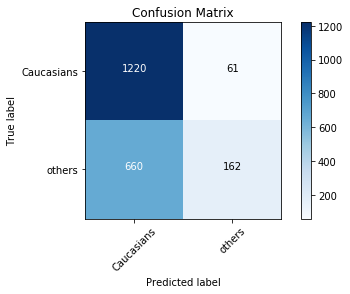

In [59]:
new_scores_Caucasian = new_scores[new_scores['race'] == 'Caucasian']
# performance.accuracy_score(new_scores_Caucasian['two_year_recid'],new_scores_Caucasian['decile_score'],normalize=True)
plot_conf_matrix(new_scores_Caucasian.two_year_recid, new_scores_Caucasian.decile_score, class_names=['Caucasians', 'others'])

### Accuracy for females

plotting the Confusion Matrix
CCR = 0.6868085106382978
Precision = 0.6706947175082781
Recall = 0.5838671649094711
[[709  53]
 [315  98]]


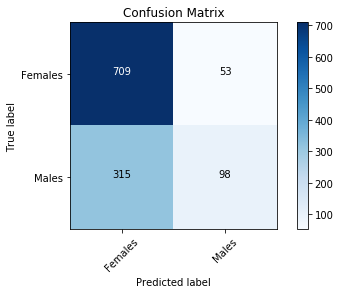

In [62]:
new_scores_female = new_scores[new_scores['sex'] == 'Female']
# performance.accuracy_score(new_scores_female['two_year_recid'],new_scores_female['decile_score'],normalize=True)
# performance.accuracy_score(new_scores_female['two_year_recid'], new_scores_female['decile_score'],normalize=True)
plot_conf_matrix(new_scores_female.two_year_recid, new_scores_female.decile_score, class_names=['Females', 'Males'])

### accuracy for males


plotting the Confusion Matrix
CCR = 0.6215729437662597
Precision = 0.6714706491896825
Recall = 0.6093971337593926
[[2357  244]
 [1647  749]]


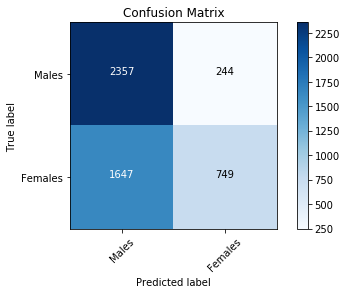

In [65]:
new_scores_male = new_scores[new_scores['sex'] == 'Male']
# performance.accuracy_score(new_scores_male['two_year_recid'],new_scores_male['decile_score'],normalize=True)
plot_conf_matrix(new_scores_male.two_year_recid, new_scores_male.decile_score, class_names=['Males', 'Females'])

5. What about false positives and false negatives?


## Part 2.2 - Standard classifiers

In [161]:
new_dataset = dataset.filter(['age', 'sex', 'race', 'age_cat', 'priors_count'])
labels = dataset.two_year_recid
new_dataset.head(5)

,age,sex,race,age_cat,priors_count
0,69,Male,Other,Greater than 45,0
1,34,Male,African-American,25 - 45,0
2,24,Male,African-American,Less than 25,4
3,44,Male,Other,25 - 45,0
4,41,Male,Caucasian,25 - 45,14


In [162]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
new_dataset.sex = le.fit_transform(new_dataset.sex)
new_dataset.race = le.fit_transform(new_dataset.race)
new_dataset.age_cat = le.fit_transform(new_dataset.age_cat)
# new_dataset.c_charge_desc = le.fit_transform(new_dataset.c_charge_desc)
# new_dataset.apply(LabelEncoder().fit_transform)

X_train, X_test, y_train, y_test = train_test_split(new_dataset, labels, test_size = 0.25, random_state = 5)



#### SVM


In [167]:
from sklearn.svm import SVC
svm_classifier = SVC(gamma=0.001, C=100.)
svm_classifier.fit(X_train, y_train)
pred = svm_classifier.predict(X_test)
performance.accuracy_score(y_test, pred, normalize=True)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [169]:
pred = svm_classifier.predict(X_test)

In [170]:
performance.accuracy_score(y_test, pred, normalize=True)

0.6921581335061568

#### MLP

In [178]:
from sklearn.neural_network import MLPClassifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,2), solver='adam', learning_rate_init = 0.001,
                              learning_rate='adaptive', momentum=0.9, batch_size = 16)

mlp_classifier.fit(X_train, y_train)
pred = mlp_classifier.predict(X_test)
performance.accuracy_score(y_test, pred, normalize=True)

0.6999351911860013

#### Decision trees

In [191]:
from sklearn.tree import DecisionTreeClassifier

tree_classifier = DecisionTreeClassifier(random_state=5, max_depth=6)
tree_classifier.fit(X_train, y_train)
pred = tree_classifier.predict(X_test)
performance.accuracy_score(y_test, pred, normalize=True)

0.6902138690861958